In [1]:
import scanpy as sc
from Alignment import *
from RGBgenerator import *
from Cross_correlation import *
from utils import *
from Preprocessing import *

In [2]:
ST1 = sc.read_h5ad('ST1.h5ad')
ST2 = sc.read_h5ad('ST2.h5ad')

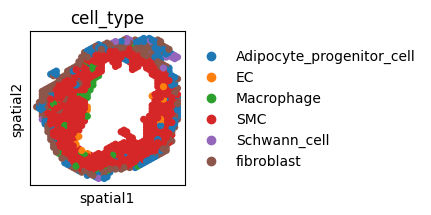

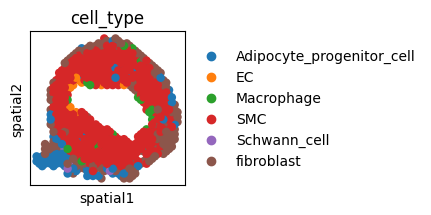

In [3]:
plt.rcParams['figure.figsize'] = [2,2]
sc.pl.embedding(ST1,basis='spatial', color='cell_type')
sc.pl.embedding(ST2, basis='spatial', color='cell_type')

# Preprocessing : Integration and dimension reduction

D:\Anaconda\envs\align\lib\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 3000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


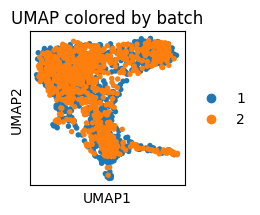

In [4]:
embedding_ST1, embedding_ST2 = dimension_reduction(ST1,ST2,reduction_dim=3,method='umap')

# Global alignment

In [5]:
spatial_ST1_normalized = normalization(ST1.obsm['spatial'])
spatial_ST2_normalized = normalization(ST2.obsm['spatial'])
ST2.obsm['spatial_norm'] = spatial_ST2_normalized

In [6]:
R, t = global_alignment(spatial_ST1_normalized, spatial_ST2_normalized, embedding_ST1,embedding_ST2)
transformed_coords = np.dot(spatial_ST1_normalized, R) + t
ST1.obsm['aligned_spatial'] = transformed_coords

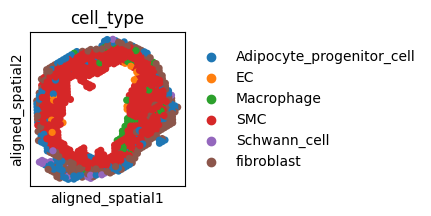

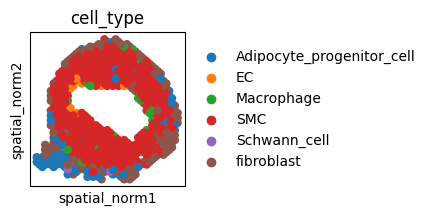

In [7]:
sc.pl.embedding(ST1,basis='aligned_spatial', color='cell_type')
sc.pl.embedding(ST2, basis='spatial_norm', color='cell_type')

# Generation of Images

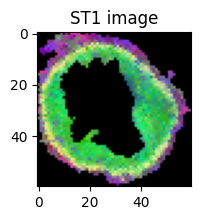

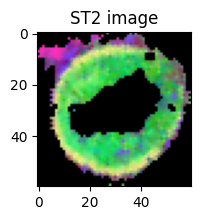

In [8]:
coords_ST1 = ST1.obsm['aligned_spatial']
ST1_generator = RGBImageGenerator(img_size=(60,60))
img_ST1, mapping_ST1 = ST1_generator.create_rgb_image_with_mapping(coords_ST1, embedding_ST1*255)
img_ST1_interpolated = ST1_generator.interpolate_zero_pixels(img_ST1)
ST1_generator.show_image(img_ST1_interpolated,title='ST1 image')

coords_ST2 = ST2.obsm['spatial_norm']
ST2_generator = RGBImageGenerator(img_size=(60,60))
img_ST2, mapping_ST2 = ST2_generator.create_rgb_image_with_mapping(coords_ST2, embedding_ST2*255)
img_ST2_interpolated = ST2_generator.interpolate_zero_pixels(img_ST2)
ST2_generator.show_image(img_ST2_interpolated,title='ST2 image')

# Global alignment

In [9]:
img_ST1_normalized = img_ST1_interpolated.astype(np.float32) / 255.0
img_ST2_normalized = img_ST2_interpolated.astype(np.float32) / 255.0

lddmm = LDDMM(grid_shape=(60, 60))
aligned_image, v_hat, energies, length, Phi0, Phi1, J0, J1 = lddmm.run_alignment(img_ST1_normalized, img_ST2_normalized, alpha=1, gamma=1, steps=32, max_iter=50, sigma=0.2,  lr=0.001)

Iter 000 | Total 31100.68 | Reg 0.00 | Match 31100.68
Iter 001 | Total 22494.47 | Reg 49.10 | Match 22445.37
Iter 002 | Total 19120.61 | Reg 81.56 | Match 19039.06
Iter 003 | Total 16920.59 | Reg 108.38 | Match 16812.21
Iter 004 | Total 15292.06 | Reg 132.12 | Match 15159.93
Iter 005 | Total 14023.96 | Reg 153.56 | Match 13870.40
Iter 006 | Total 12805.66 | Reg 172.80 | Match 12632.86
Iter 007 | Total 11800.70 | Reg 189.68 | Match 11611.02
Iter 008 | Total 11023.82 | Reg 204.77 | Match 10819.05
Iter 009 | Total 10377.15 | Reg 218.53 | Match 10158.62
Iter 010 | Total 9948.84 | Reg 231.25 | Match 9717.59
Iter 011 | Total 9419.28 | Reg 243.15 | Match 9176.13
Iter 012 | Total 8818.32 | Reg 254.03 | Match 8564.30
Iter 013 | Total 8304.44 | Reg 263.75 | Match 8040.69
Iter 014 | Total 7923.56 | Reg 272.33 | Match 7651.24
Iter 015 | Total 7659.27 | Reg 279.95 | Match 7379.33
Iter 016 | Total 7450.12 | Reg 286.89 | Match 7163.23
Iter 017 | Total 7257.60 | Reg 293.32 | Match 6964.29
Iter 018 | T

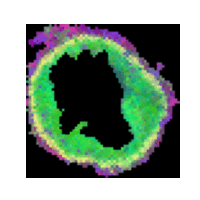

In [10]:
generate_gif_from_sequence(J0, gif_path="output/J0_demo.gif", duration=80)

In [11]:
mapped_img_ST1, new_coords_ST1 = direct_image_mapping_with_coords(img_ST1,Phi1[0], mapping_ST1)
ST1.obsm['fine_aligned_spatial'] = new_coords_ST1
cell_positions_in_img_ST2 = find_cell_positions_in_image(coords_ST2, img_size=(60, 60))
ST2.obsm['spatial_image'] = cell_positions_in_img_ST2

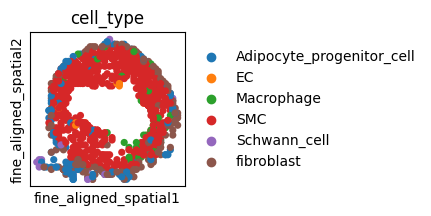

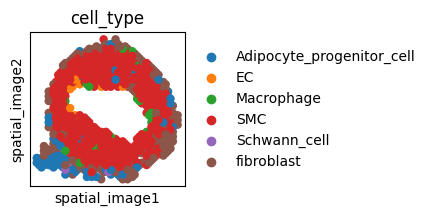

In [12]:
# Slices after local alignment
sc.pl.embedding(ST1, basis='fine_aligned_spatial', color='cell_type')
sc.pl.embedding(ST2, basis='spatial_image', color='cell_type')

# Spatial analysis

In [14]:
scc = SpatialCrossCorrelation(ST1, ST2,
                              coord_key_1='fine_aligned_spatial',
                              coord_key_2='spatial_image',
                              beta=1.0)

results = scc.compute_cross_correlation()

for gene, score in results[:10]:
    print(f"{gene}\t{score:.4f}")

MYL9	0.5009
TAGLN	0.4647
ACTA2	0.4182
APOD	0.3275
FN1	0.3258
FLNA	0.3197
MYH11	0.3192
TPM2	0.3097
CFD	0.2966
LINC00632	0.2910
